In [1]:
from qutip import *
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt
from scipy.special import genlaguerre as L

In [9]:
hbar = sp.constants.hbar
h = sp.constants.h
c = sp.constants.c
e = sp.constants.e
eVtoJ = 1.602176634e-19
amutokg = 1.66053906660e-27

In [2]:
def psi(g,e):
    return np.array([g, e])

def pulse(t, Omega0, delta, phi0, phi1):
    Omega = np.sqrt(Omega0**2 + delta**2)
    
    if Omega == 0.0:
        U = np.array([[1.0 , 0.0],
                      [0.0 , 1.0]])
        
    else:
        U = np.array([[np.cos(Omega*t/2.0) -(1.0j*delta/Omega)*np.sin(Omega*t/2.0), (1.0j*Omega0/Omega)*np.sin(Omega*t/2.0)],
                     [(1.0j*Omega0/Omega)*np.sin(Omega*t/2.0) , np.cos(Omega*t/2.0) + (1.0j*delta/Omega)*np.sin(Omega*t/2.0)]])
    
    V1 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(-1.0j*phi1)]])
    
    V0 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(1.0j*phi0)]])
    
    return np.exp(1.0j*delta*t/2.0)*V1@U@V0

def thermPulse(psi0, t, Omega0, delPrime, eta, nbar, Ncut): #1-dimensional
    result = psi(0.0+0.0j,0.0+0.0j)
    for n in range(Ncut):
        result += prob(n,nbar)*pulse(t, Omega0*Omega(n,0,eta), delPrime, 0.0, 0.0)@psi0
    return result

def therm3DPulse(psi0, t, Omega0, delPrime, nbars, Omegas, Ncut):
    nbarx = nbars[0]
    nbary = nbars[1]
    nbarz = nbars[2]
    #Ncut = 100
    result = psi(0.0+0.0j,0.0+0.0j)
    for nx in range(Ncut):
        Probx = prob(nx,nbarx)
        for ny in range(Ncut):
            Probxy = Probx*prob(ny,nbary)
            for nz in range(Ncut):
                result += Probxy*prob(nz,nbarz)*pulse(t, Omega0*Omegas[nx,ny,nz], delPrime, 0.0, 0.0)@psi0
    return result

def rhoee(psi):
    return (abs(psi[1]))**2.0

def rhogg(psi):
    return (abs(psi[0]))**2.0

def prob(n,nbar):
    return 1.0/(nbar+1)*(nbar/(nbar+1))**n    #returns prob of being in state n given nbar

def Omega(n,m,eta):
    return np.exp(-eta**2/2.0) * eta**(np.abs(m)) * (math.factorial(n)/math.factorial(n+m))**(np.sign(m)/2.0) \
        * L(n,np.abs(m))(eta**2)              #returns unitless rabi rate of transition n -> n+m given Lamb-Dicke Parameter

In [10]:
def prob(n,nbar):
    return 1.0/(nbar+1)*(nbar/(nbar+1))**n

def expE(nbar, omega, Ncut):
    expE = 0.0
    #Ncut = 1001
    for n in range(Ncut):
        expE += prob(n,nbar)*hbar*omega*(0.5+n)
    return expE

def expEHeat(nbar0, nbarf, omega, Ncut):
    return expE((nbar0+nbarf)/2.0, omega, Ncut)

def dopAndStark(nbar):
    Ncut = 1201
    nbar0 = 0.0
    omega = 2.0*np.pi*778e3 #Lange
    Omegarf = 2.0*np.pi*13e6 #Lange
    m = 170.936331517*amutokg
    alpha = 5.89e-40 #J m^2 V^-2 E2 transition (Lange)
    nu0 = 688358979309307.82 #Hz E2 transition (Huntemann)
    return -nu0*expEHeat(nbar0, nbar, omega, Ncut)*(3.0/(m*c**2) + (alpha/(h*nu0))*(3.0*m*Omegarf**2/(2.0*e**2)))

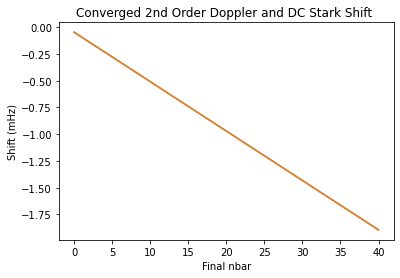

In [11]:
pts = 5
nbarfs = np.linspace(0, 40, pts)
Ncut = 1201
nbar0 = 0.0
shifts = -expEHeat(nbar0, nbarfs, omega, Ncut)*(3.0/(m*c**2) + (alpha/(h*nu0))*(3.0*m*Omegarf**2/(2.0*e**2)))
dopAndStarks = dopAndStark(nbarfs)
plt.plot(nbarfs,shifts*nu0*1.0e3, label="Ncut=1201")
plt.plot(nbarfs, dopAndStarks*1e3)
plt.xlabel("Final nbar")
plt.ylabel("Shift (mHz)")
plt.title("Converged 2nd Order Doppler and DC Stark Shift ")
plt.show()

In [52]:
def RamseyErrSig(deld, psi0, t1, T, t2, delPrime, Omega0, eta, nbar0, nbarf, Ncut):
    #nbar = nbar0 + nbardot*T
    #delPrime = deld - Delta
    delp1 = dopAndStark(nbar0)
    delp2 = delPrime + dopAndStark(nbarf)

    freeEvo = pulse(T, 0.0, deld, 0.0, 0.0)
    pi2PhaseInjP = pulse(0.0, 0.0, 0.0, 0.0, np.pi/2.0)
    pi2PhaseInjM = pulse(0.0, 0.0, 0.0, 0.0, -np.pi/2.0)
    intState = thermPulse(psi0, t1, Omega0, delp1, eta, nbar0, Ncut)
    resultP = thermPulse(freeEvo@pi2PhaseInjP@intState, t2, Omega0, delp2, eta, nbarf, Ncut)
    resultM = thermPulse(freeEvo@pi2PhaseInjM@intState, t2, Omega0, delp2, eta, nbarf, Ncut)
    return rhoee(resultP) - rhoee(resultM)

def HRJumpThermErrSig(deld, psi0, t1, T, t2, delPrime, Omega0, eta, nbar0, nbarf, Ncut):
    #delPrime = deld - Delta
    delp1 = delPrime + dopAndStark(nbar0)
    delp2 = delPrime + dopAndStark(nbarf)
    freeEvo = pulse(T, 0.0, deld, 0.0, 0.0)
    pi2PhaseInjP = pulse(0.0, 0.0, 0.0, 0.0, np.pi/2.0)
    pi2PhaseInjM = pulse(0.0, 0.0, 0.0, 0.0, -np.pi/2.0)
    #def thermPulse(psi0, t, Omega0, delPrime, eta, nbar, Ncut): #1-dimensional
    intState = thermPulse(psi0, t1, Omega0, delp1, eta, nbar0, Ncut)
    resultP = thermPulse(thermPulse(freeEvo@pi2PhaseInjP@intState, 2.0*t2/3.0, -Omega0, delp2, eta, nbarf, Ncut), t2/3.0, Omega0, delp2, eta, nbarf, Ncut)
    resultM = thermPulse(thermPulse(freeEvo@pi2PhaseInjM@intState, 2.0*t2/3.0, -Omega0, delp2, eta, nbarf, Ncut), t2/3.0, Omega0, delp2, eta, nbarf, Ncut)
    return rhoee(resultP) - rhoee(resultM)

In [87]:
Ncut = 401
pts = 5
nbarfs = np.linspace(0, 40, pts)
psi0 = psi(0.0, 1.0)
delPrime = -0.005*2.0*np.pi #hz
t1 = 20.0e-3
t2 = 3.0*t1
Omega0 = np.pi/(2.0*t2) #hz
T = 500.0e-3
eta = 0.05
shifts1 = np.zeros(pts)
nbarfStars = nbarfs*(t1+T)/(t1+t2+T)
nbar0s = nbarfs*t1/(t1+t2+T)

tol = 1.0e-11
x0 = -0.1
x1 = 0.5
guessTol = 0.1

for ii in range(pts):
    print(nbarfs[ii])
    shifts1[ii] = sp.optimize.root_scalar(HRJumpThermErrSig, args=(psi0, t1, T, t2, delPrime, Omega0, eta, 0.0, nbarfs[ii], Ncut), bracket=[x0,x1], xtol = tol).root
    print(shifts1[ii])
    x0 = shifts1[ii] - guessTol
    x1 = shifts1[ii] + guessTol
    #print(x0,x1)

0.0
0.0006430401719550393
10.0
0.0006335914200595336
20.0
0.0006241631641481833
30.0
0.0006147547259115951
40.0
0.0006053659559323604


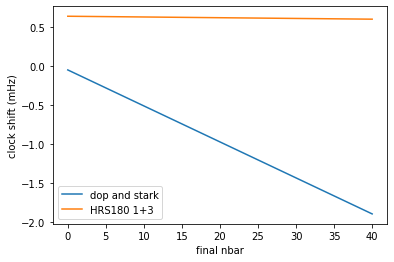

In [89]:
plt.plot(nbarfs, dopAndStarks*1e3, label="dop and stark")
plt.plot(nbarfs, shifts1*1e3, label="HRS180 1+3")
plt.xlabel("final nbar")
plt.ylabel("clock shift (mHz)")
plt.legend()
plt.show()

In [53]:
Ncut = 401
pts = 5
nbarfs = np.linspace(0, 40, pts)
psi0 = psi(0.0, 1.0)
delPrime = -0.01*2.0*np.pi #hz
t1 = 20.0e-3
t2 = t1
Omega0 = np.pi/(2.0*t2) #hz
T = 500.0e-3
eta = 0.05
shifts1 = np.zeros(pts)
nbarfStars = nbarfs*(t1+T)/(t1+t2+T)
nbar0s = nbarfs*t1/(t1+t2+T)

tol = 1.0e-11
x0 = -0.1
x1 = 0.5
guessTol = 0.1

for ii in range(pts):
    print(nbarfs[ii])
    shifts1[ii] = sp.optimize.root_scalar(RamseyErrSig, args=(psi0, t1, T, t2, delPrime, Omega0, eta, 0.0, nbarfs[ii], Ncut), bracket=[x0,x1], xtol = tol).root
    print(shifts1[ii])
    x0 = shifts1[ii] - guessTol
    x1 = shifts1[ii] + guessTol
    #print(x0,x1)

0.0
0.0016012130155790365
10.0
0.001591195821649673
20.0
0.0015829502861452146
30.0
0.0015762890567860885
40.0
0.0015710599882697008


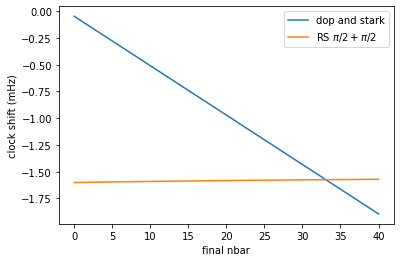

In [54]:
plt.plot(nbarfs, dopAndStarks*1e3, label="dop and stark")
plt.plot(nbarfs, -shifts1*1e3, label=r"RS $\pi/2+\pi/2$")
plt.xlabel("final nbar")
plt.ylabel("clock shift (mHz)")
plt.legend()
plt.show()

In [62]:
def MHRSthermPulse(psi0, t, Omega0, delPrime, phi0, phi1, eta, nbar, Ncut): #1-dimensional
    result = psi(0.0+0.0j,0.0+0.0j)
    for n in range(Ncut):
        result += prob(n,nbar)*pulse(t, Omega0*Omega(n,0,eta), delPrime, phi0, phi1)@psi0
    return result

def HRAThermp(deld, psi0, t, T, delPrime, Omega0, eta, nbar0, nbarf, Ncut):
    #thermPulse(psi0, t, Omega0, delPrime, phi0, phi1, eta, nbar, Ncut):
    #delPrime = deld - Delta
    delp1 = delPrime + dopAndStark(nbar0)
    delp2 = delPrime + dopAndStark(nbarf)
    freeEvo = pulse(T, 0.0, deld, 0.0, 0.0)
    state1 = MHRSthermPulse(psi0, t, Omega0, delp1, np.pi/2.0, -np.pi/2.0, eta, nbar0, Ncut)
    state2 = freeEvo@state1
    state3 = MHRSthermPulse(state2, 2.0*t, Omega0, delp2, np.pi, -np.pi, eta, nbarf, Ncut)
    state4 = MHRSthermPulse(state3, t, Omega0, delp2, 0.0, 0.0, eta, nbarf, Ncut)
    return state4

def HRAThermn(deld, psi0, t, T, delPrime, Omega0, eta, nbar0, nbarf, Ncut):
    #delPrime = deld - Delta
    delp1 = delPrime + dopAndStark(nbar0)
    delp2 = delPrime + dopAndStark(nbarf)
    freeEvo = pulse(T, 0.0, deld, 0.0, 0.0)
    state1 = MHRSthermPulse(psi0, t, Omega0, delp1, -np.pi/2.0, np.pi/2.0, eta, nbar0, Ncut)
    state2 = freeEvo@state1
    state3 = MHRSthermPulse(state2, 2.0*t, Omega0, delp2, np.pi, -np.pi, eta, nbarf, Ncut)
    state4 = MHRSthermPulse(state3, t, Omega0, delp2, 0.0, 0.0, eta, nbarf, Ncut)
    return state4
    
def HRBThermp(deld, psi0, t, T, delPrime, Omega0, eta, nbar0, nbarf, Ncut):
    #delPrime = deld - Delta
    delp1 = delPrime + dopAndStark(nbar0)
    delp2 = delPrime + dopAndStark(nbarf)
    freeEvo = pulse(T, 0.0, deld, 0.0, 0.0)
    state1 = MHRSthermPulse(psi0, t, Omega0, delp1, 0.0, 0.0, eta, nbar0, Ncut)
    state2 = freeEvo@state1
    state3 = MHRSthermPulse(state2, 2.0*t, Omega0, delp2, np.pi, -np.pi/2.0, eta, nbarf, Ncut)
    state4 = MHRSthermPulse(state3, t, Omega0, delp2, 0.0, -np.pi/2.0, eta, nbarf, Ncut)
    return state4

def HRBThermn(deld, psi0, t, T, delPrime, Omega0, eta, nbar0, nbarf, Ncut):
    #delPrime = deld - Delta
    delp1 = delPrime + dopAndStark(nbar0)
    delp2 = delPrime + dopAndStark(nbarf)
    freeEvo = pulse(T, 0.0, deld, 0.0, 0.0)
    state1 = MHRSthermPulse(psi0, t, Omega0, delp1, 0.0, 0.0, eta, nbar0, Ncut)
    state2 = freeEvo@state1
    state3 = MHRSthermPulse(state2, 2.0*t, Omega0, delp2, np.pi, -3.0*np.pi/2.0, eta, nbarf, Ncut)
    state4 = MHRSthermPulse(state3, t, Omega0, delp2, 0.0, np.pi/2.0, eta, nbarf, Ncut)
    return state4

def MHRThermES1(deld, psi0, t, T, delPrime, Omega0, eta, nbar0, nbarf, Ncut):
    return rhoee(HRAThermp(deld, psi0, t, T, delPrime, Omega0, eta, nbar0, nbarf, Ncut)) - rhoee(HRBThermn(deld, psi0, t, T, delPrime, Omega0, eta, nbar0, nbarf, Ncut))
def MHRThermES2(deld, psi0, t, T, delPrime, Omega0, eta, nbar0, nbarf, Ncut):
    return rhoee(HRBThermp(deld, psi0, t, T, delPrime, Omega0, eta, nbar0, nbarf, Ncut)) - rhoee(HRAThermn(deld, psi0, t, T, delPrime, Omega0, eta, nbar0, nbarf, Ncut))

In [81]:
Ncut = 401
pts = 5
nbarfs = np.linspace(0, 40, pts)
psi0 = psi(0.0, 1.0)
delPrime = 0.000*2.0*np.pi #hz
t = 20.0e-3
#t2 = t1|
Omega0 = np.pi/(2.0*t) #hz
T = 500.0e-3
eta = 0.05
shifts1 = np.zeros(pts)
nbarfStars = nbarfs*(t1+T)/(t1+t2+T)
nbar0s = nbarfs*t1/(t1+t2+T)

tol = 1.0e-11
x0 = -0.1
x1 = 0.5
guessTol = 0.1

for ii in range(pts):
    print(nbarfs[ii])
    shifts1[ii] = sp.optimize.root_scalar(MHRThermES2, args=(psi0, t, T, delPrime, Omega0, eta, 0.0, nbarfs[ii], Ncut), bracket=[x0,x1], xtol = tol).root
    print(shifts1[ii])
    x0 = shifts1[ii] - guessTol
    x1 = shifts1[ii] + guessTol
    #print(x0,x1)

0.0
9.98930169251376e-15
10.0
0.0031380322909198475
20.0
0.0119374573512876
30.0
0.025885860435927673
40.0
0.044439221002068235


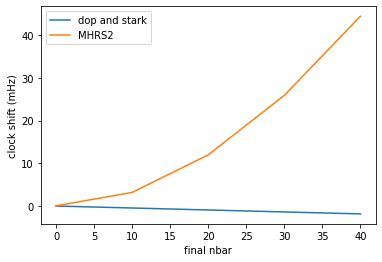

In [82]:
shifts2 = np.array([9.843270830126955e-15, 0.003094119008543164, 0.011847479777193437, 0.025747615755507693 , 0.04425054078469512])
plt.plot(nbarfs, dopAndStarks*1e3, label="dop and stark")
plt.plot(nbarfs, shifts1*1e3, label="MHRS2")

plt.xlabel("final nbar")
plt.ylabel("clock shift (mHz)")
plt.legend()
plt.show()